# Jax

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

## Jax is autograd and XLA

In [2]:
import jax
import jax.numpy as jnp # jax version of numpy

# Why jax?
Gradients, linear algebra, and vectorisation operations are ubiquitous in machine learning

* Jax is numpy for machine learning
* Jax is numpy +
    1. Gradients
    2. non-trivial vectorisations
    3. parallelisation
    4. speed

## A first program with jax

In [3]:
def f(x):
    return jnp.sin(x)

In [4]:
f(0.0)

Array(0., dtype=float32, weak_type=True)

## (Almost) everything we can do in numpy we can do in jax

`jax.numpy` is a drop-in replacement for `numpy`. Some examples

In [5]:
jnp.arange(10) # np.arange(10)
jnp.linspace(0, 1, 100) # np.linspace(0, 1, 100)
jnp.sin # np.sin
jnp.linalg.solve # np.linalg.solve

<PjitFunction of <function solve at 0x7ff62cc64670>>

# Not all we can do in jax we can do in numpy

## Gradients in jax
For a given function `f`, we can compute the *exact* gradient of `f` with respect to the first parameter in the function as
`jax.grad(f)`.
For example

In [6]:
df = jax.grad(f) # cos(x)
df(0.0) # cos(0)

Array(1., dtype=float32, weak_type=True)

Gradients are defined for scalar-output functions.

An important implication is that if scalar-output function is vectorisable,
the gradient of that scalar-output is not vectorisible.
This is because if we evaluate `f` using an `n`-dimensional array `xv`, then `len(f(xv)) == n`,
which would make it non-scalar.

Consider the following example for `f(x) = sin(x)`.
We can evaluate the function over a given array of values as we would in numpy

In [7]:
def f(x): return jnp.sin(x)

xv = jnp.linspace(-jnp.pi, jnp.pi, 100)
f(xv)

Array([ 8.7422784e-08, -6.3423857e-02, -1.2659244e-01, -1.8925104e-01,
       -2.5114805e-01, -3.1203350e-01, -3.7166259e-01, -4.2979503e-01,
       -4.8619670e-01, -5.4064083e-01, -5.9290773e-01, -6.4278746e-01,
       -6.9007891e-01, -7.3459160e-01, -7.7614641e-01, -8.1457585e-01,
       -8.4972537e-01, -8.8145334e-01, -9.0963197e-01, -9.3414789e-01,
       -9.5490223e-01, -9.7181165e-01, -9.8480773e-01, -9.9383849e-01,
       -9.9886733e-01, -9.9987411e-01, -9.9685478e-01, -9.8982149e-01,
       -9.7880250e-01, -9.6384221e-01, -9.4500089e-01, -9.2235434e-01,
       -8.9599377e-01, -8.6602527e-01, -8.3256984e-01, -7.9576182e-01,
       -7.5574952e-01, -7.1269429e-01, -6.6676903e-01, -6.1815906e-01,
       -5.6705993e-01, -5.1367742e-01, -4.5822650e-01, -4.0093049e-01,
       -3.4202030e-01, -2.8173247e-01, -2.2031064e-01, -1.5800147e-01,
       -9.5055975e-02, -3.1728067e-02,  3.1727828e-02,  9.5055975e-02,
        1.5800147e-01,  2.2031052e-01,  2.8173259e-01,  3.4202018e-01,
      

However, evaluating the gradient of the inputs w.r.t. the input vector would return an error
since the output is **not** scalar.

In [8]:
df = jax.grad(f)
df(xv)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (100,).

## Vectorising single-output-valued functions: `jax.vmap`

To overcome the problem above, we can use the `jax.vmap` function to declare which parameters should be considered element-wise.
The function `jax.vmap` both takes and returns a function whose inputs are evaluated element-wise.

Consider a one-dimensional array `x.shape == (N,)` and a function `f`. Calling `jax.vmap(f)(x)` amounts to evaluating.
```python
jax.vmap(f)(x) = [f(x[0]), f(x[1]), ..., f(x[-1])]
```

Note that `jax.vmap(f)` is a function itself, so it's common to store this function inside a variable.

## Example
Let's consider the example above. To evaluate the gradient of `f` on all the datapoints of the array`xv`,
we define a new function `vdf` that acts *elementwise* on `df`.

In [ ]:
# Vectorised derivative of f
vdf = jax.vmap(df)
vdf(xv)

In the code above, calling `vdf(x)` can be thought of as calling
```python
vdf(x) = [jax.grad(f)(x[0]), jax.grad(f)(x[1]), ..., jax.grad(f)(x[-1])]
```

### Example
Plotting `f(x)` and `df(x)`.

In [ ]:
x = jnp.linspace(-jnp.pi, jnp.pi, 100)
plt.plot(x, f(x), label="f(x)")
plt.plot(x, vdf(x), label="df/dx(x)")
plt.legend()
plt.grid(alpha=0.3)

## practical considertions using `jax.vmap`

For a function `f(x,y,z)`, then
```python
jax.vmap(f)(x,y,z) = [f(x[0], y[0], z[0]), ..., f(x[-1], y[-1], z[-1])]
```

At times, we want to vectorise over a single parameter and treat other parameters as fixed. For the example above, suppose we seek to evaluate 
```python
[f(x[0], y, z), ..., f(x[-1], y, z)]
```

or perhaps we want to evaluate
```python
[f(x[0], y, z[0]), ..., f(x[-1], y, z[-1])]
```

Or, if `x.shape = (N, M)`, suppose we want to vectorise over the second axis to obtain
```python
[f(x[:, 0], y, z), ..., f(x[:, -1], y, z)]
```

In all cases above, we can make use of the `in_axes` parameter in `jax.vmap`.
<!-- This parameter specifies over which parameters we want to vectorise over. -->
The `in_axes` parameter, if specified, eiter takes an integer that specifies over which axes all parameters should be evaluated over (`in_axes=0` by default), or a tuple that has the same length as number of parameters in the function. In the latter case, each tuple has either an `int` indicating which axes to map over a specific parameter or `None` if the element should be taken as-is.

For the examples above, vectorising the function `f(x,y,z)` using `jax.vmap` over the first axes of the first parameter (`x`) and fixing `y` and `z` is done as
```python
jax.vmap(f)(in_axes=(0, None, None))(x, y, z) = [f(x[0], y, z), ..., f(x[-1], y, z)]
```

Vectorising `f(x,y,z)` over the first first axes of `x` and `z` and fixing `y`
```python
jax.vmap(f)(in_axes=(0, None, 0))(x, y, z) = [f(x[0], y, z[0]), ..., f(x[-1], y, z[-1])]
```

### Exercise: the density and derivative of the density for a Normally-distributed random variable

Take
$$
    f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2\sigma^2}(x - \mu)^2\right)
$$

In [9]:
def f(x, mu, sigma2):
    return 1 / jnp.sqrt(jnp.pi * sigma2) * jnp.exp(-(x - mu) ** 2 / (2 * sigma2))


df = jax.vmap(jax.grad(f), in_axes=(0, None, None))

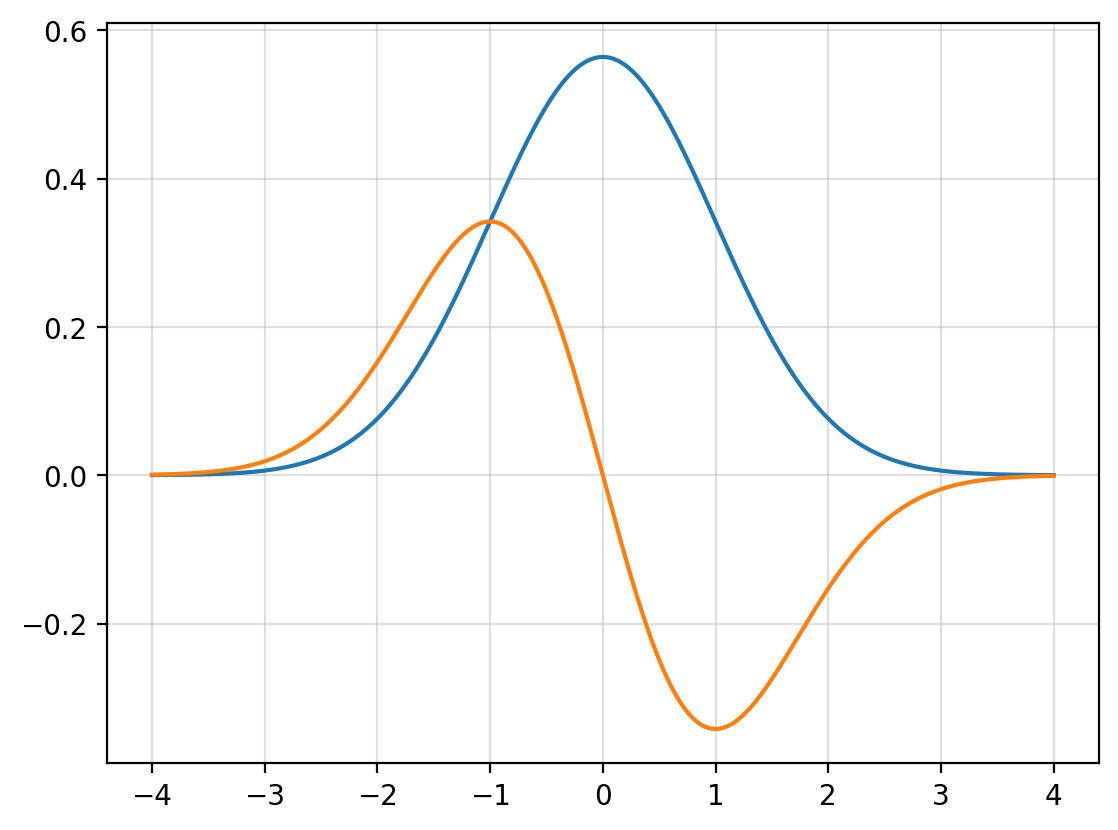

In [10]:
xrange = jnp.linspace(-4, 4, 500)
mu = 0.0
sigma2 = 1.0

plt.plot(xrange, f(xrange, mu, sigma2))
plt.plot(xrange, df(xrange, mu, sigma2))
plt.grid(alpha=0.4)

## Compositions of `jax.vmap`
Suppose we're interested in evaluating `f(x: float, mu: float, sigma:float) -> float`
using an array `xv.shape == (N,)`, `sigmav.shape==(M,)`, and fixed `mu`.
In this example, we want to obtain an `(N,M)` array such that the
`(n,m)`-th entry is given by
is given by
```python
    f(x[n], mu, sigma[m])
```

and more generally
```python
[
    [f(x[0], mu, sigma[0]), ..., f(x[0], mu, sigma[-1])],
    ...,
    [f(x[-1], mu, sigma[0]), ..., f(x[-1], mu, sigma[-1])],
]
```

To obtain the desired array above, we can use `jax.vmap`

To this using `vmap`, we can do a function composition of `vmap`. Consider the following program

```python
jax.vmap(jax.vmap(f, in_axes=(None, None, 0), in_axes=(0, None, None)))(x, mu, sigma)
= [
    jax.vmap(f, in_axes=(0, None, None)(x, mu, sigma[0]),
    ...,
    jax.vmap(f, in_axes=(0, None, None)(x, mu, sigma[-1]),
] # M calls to the function (cols)
= [
    [f(x[0], mu, sigma[0]), ..., f(x[-1], mu, sigma[0])],
    ...
    [f(x[0], mu, sigma[-1]), ..., f(x[-1], mu, sigma[-1])],
] # N x M calls to the function (rows, cols)
```

## Example
Evaluate the density of a zero-mean Gaussian for multiple standard deviations.

In [23]:
# Define composite function:
# 1. evaluate density for varying sigma2
fv = jax.vmap(f, in_axes=(None, None, 0))
# 2. evaluate density at different points of the domain
fv = jax.vmap(fv, in_axes=(0, None, None))

xrange = jnp.linspace(-4, 4, 500)
sigma_values = jnp.array([0.1, 0.5, 1.0, 5.0])

density_sigmas = fv(xrange, mu, sigma_values)
density_sigmas.shape

(500, 4)

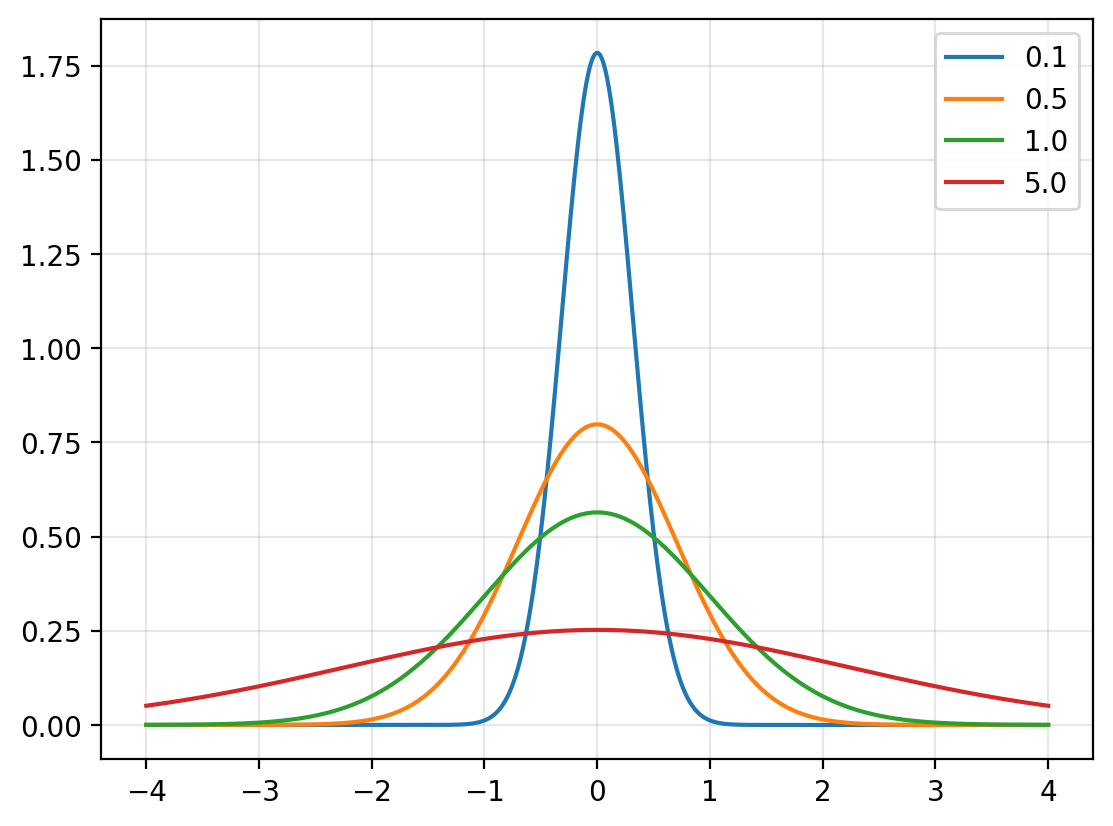

In [24]:
plt.plot(xrange, density_sigmas, label=sigma_values)
plt.legend()
plt.grid(alpha=0.3)

### Exercise:
Evaluate `df/dx` over multiple values of `sigma`, where `f` is defined in the following cell

In [26]:
def f(x, mu, sigma2):
    return 1 / jnp.sqrt(jnp.pi * sigma2) * jnp.exp(-(x - mu) ** 2 / (2 * sigma2))

In [27]:
sigma_values = jnp.array([0.3, 0.5, 1.0, 3.0])

In [28]:
dfv = jax.vmap(jax.grad(f), in_axes=(0, None, None))
dfv = jax.vmap(dfv, in_axes=(None, None, 0))

dfv(xrange, mu, sigma_values).shape

(4, 500)

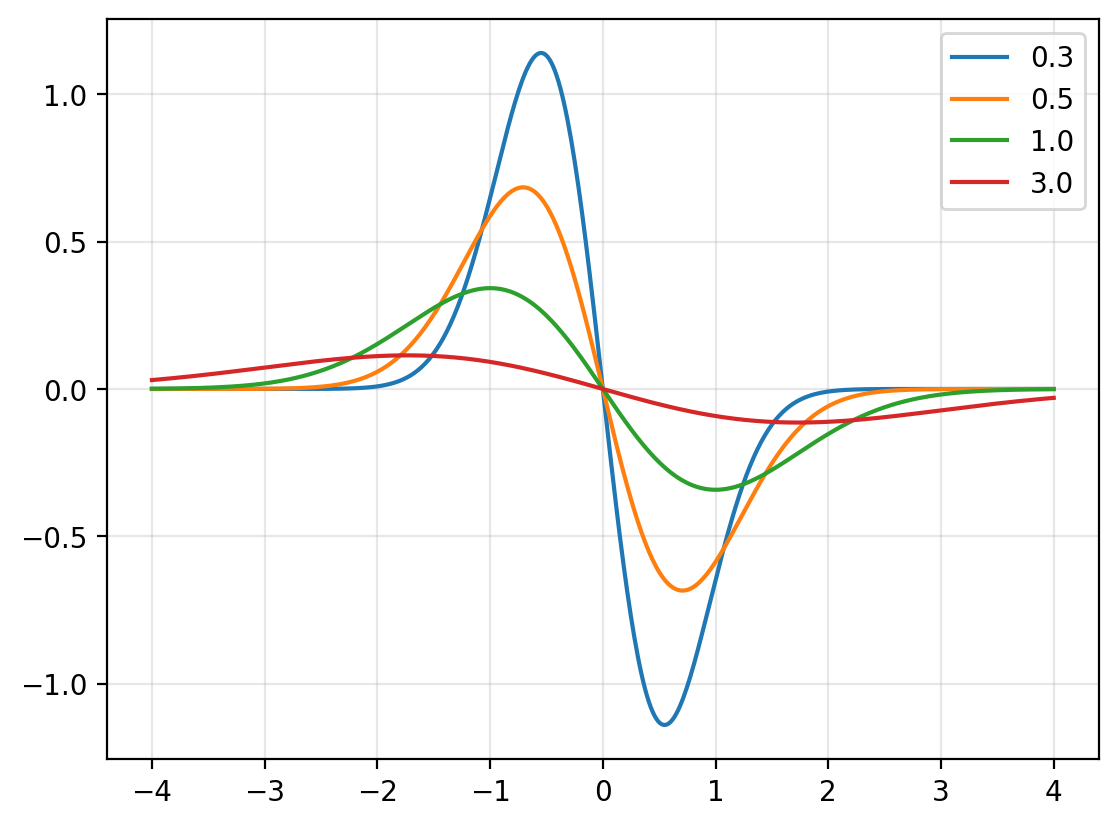

In [29]:
plt.plot(xrange, dfv(xrange, mu, sigma_values).T, label=sigma_values)
plt.legend()
plt.grid(alpha=0.3)

## Higher order derivatives in jax
### Jacobians

### Example: first-order optimisation of a non-linear function

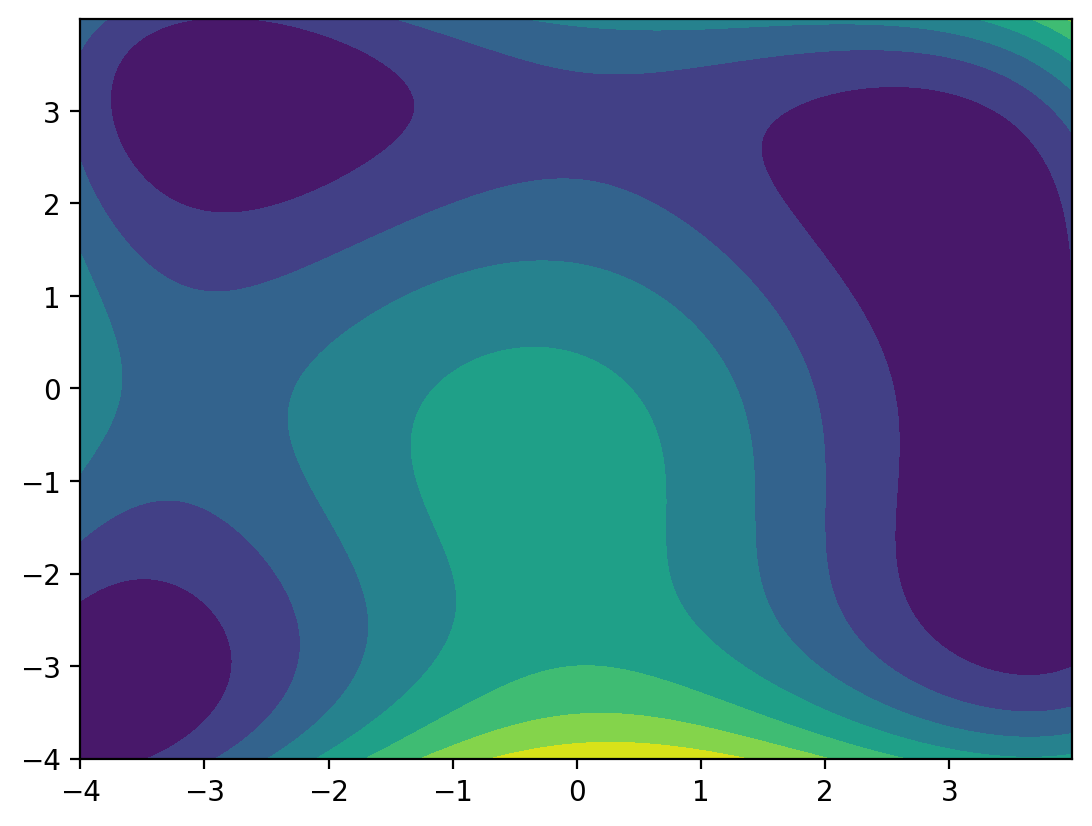

In [30]:
def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

X = jnp.mgrid[-4:4:0.01, -4:4:0.01]

plt.contourf(*X, f(*X))

In [ ]:
jax.